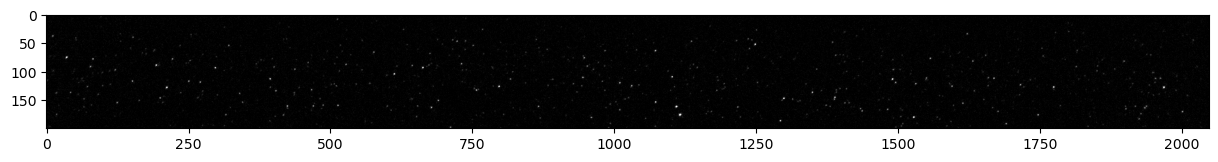

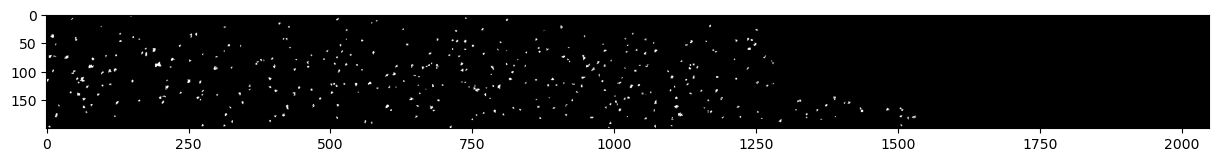

In [3]:
# Set proper path
import os
current_dir = os.getcwd()
if "notebooks" in current_dir:
    current_dir = os.chdir("../")

# Import libraries
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from src.data.build_mask import build_mask

# Replace 'path_to_your_image' with the actual path to your image (relative to the root of the project)
image_path = 'data/interim/batch1/cam0/B00002.im7.png'

# Open the image file
img = Image.open(image_path)

# make it a numpy array
img = np.array(img)

# Plot the image in big format
plt.figure(figsize=(15, 15))
plt.imshow(img, cmap='gray')
plt.show()

json_path = "data/raw/masks/mask_joachim1.json"
mask = build_mask(json_path)

# Plot mask
plt.figure(figsize=(15, 15))
plt.imshow(mask, cmap='gray')
plt.show()

### MASKS IN SEQUENCE WITH IMAGE BEFORE AND AFTER

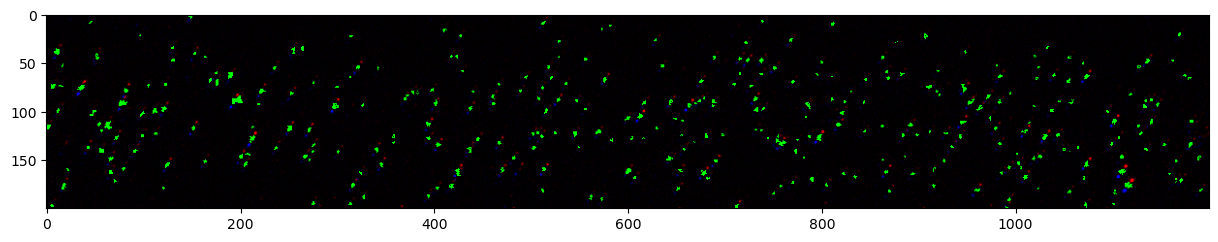

In [4]:
img1_path = 'data/interim/batch1/cam0/B00001.im7.png'
img3_path = 'data/interim/batch1/cam0/B00003.im7.png'

# Stack img1, ar2 and img3 as a three channel image
img1 = Image.open(img1_path)
img1 = np.array(img1)

img3 = Image.open(img3_path)
img3 = np.array(img3)

# Stack the images
img_stacked = np.stack((img1, mask, img3), axis=-1)

# Plot the image in big format
plt.figure(figsize=(15, 15))
plt.imshow(img_stacked.astype("int")[:,:1200,:])
plt.show()

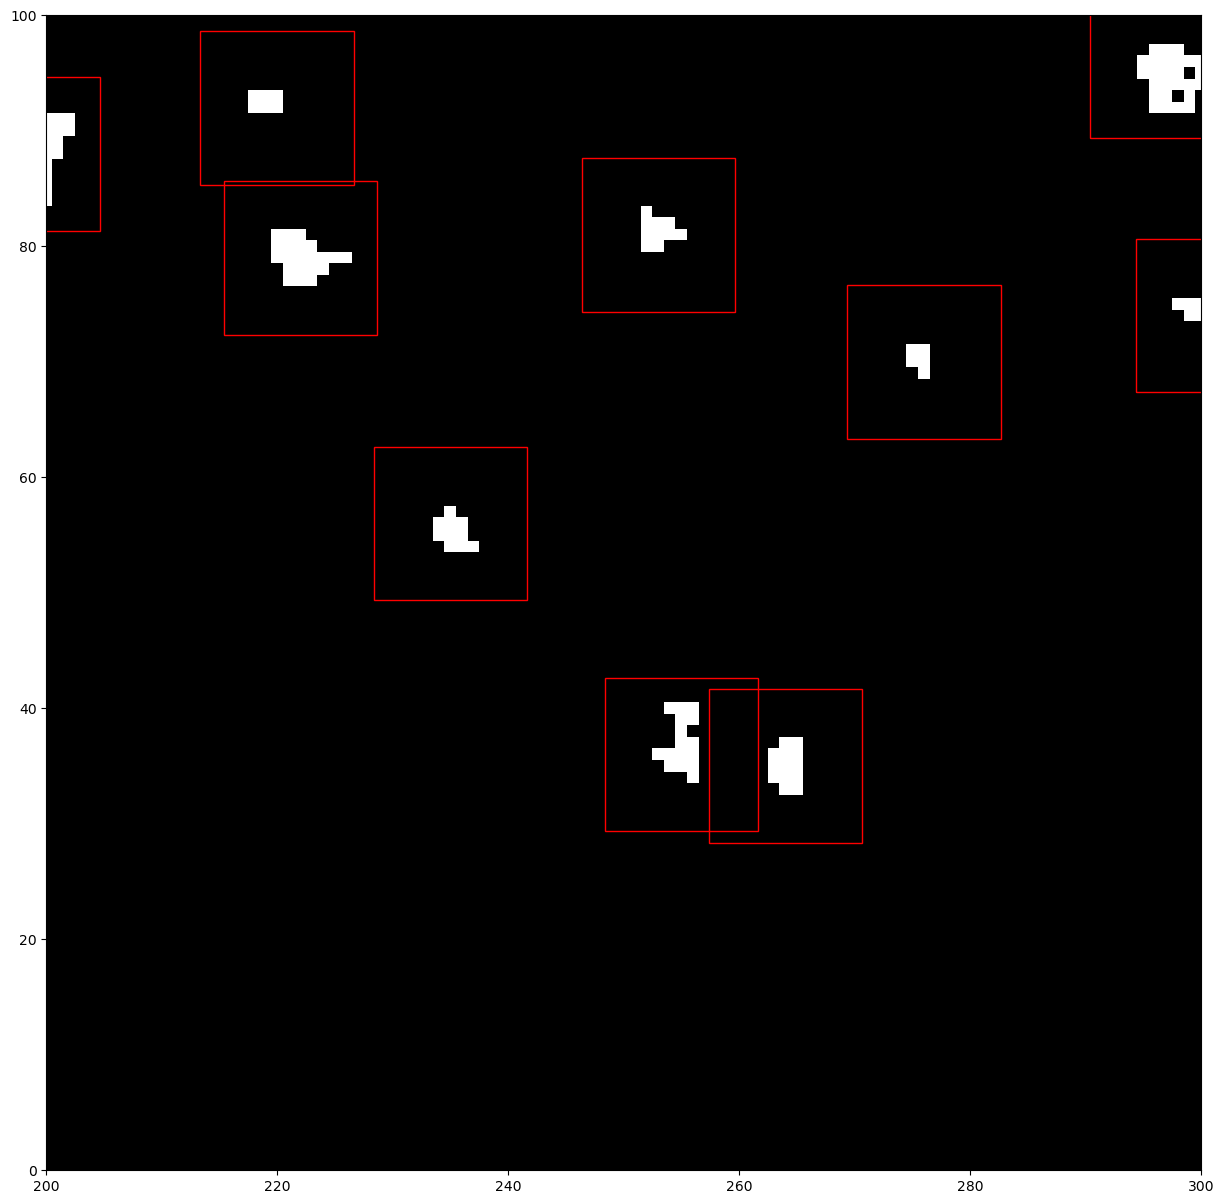

In [5]:
from matplotlib.patches import Rectangle
import scipy.ndimage as ndimage
import matplotlib.pyplot as plt

# Label connected components in the mask
labels, num_labels = ndimage.label(mask)

# Calculate the Euclidean distance transform of the labeled mask
distances = ndimage.distance_transform_edt(mask)

# Find the maximum position (centroid) of each labeled component
centroids = ndimage.maximum_position(distances, labels, range(1, num_labels + 1))

# Calculate the radius that surrounds all the points in the grouping
max_distance = distances.max()
radius = max_distance*2 + 1

# Plot the mask
plt.figure(figsize=(15, 15))
plt.imshow(mask, cmap='gray')
shift= 200
plt.xlim(0+shift, 100+shift)
plt.ylim(0, 100)

# Plot rectangles for each centroid
for centroid in centroids:
    x = centroid[1] - radius
    y = centroid[0] - radius
    width = 2 * radius
    height = 2 * radius
    rectangle = Rectangle((x, y), width, height, facecolor='none', edgecolor='r')
    plt.gca().add_patch(rectangle)

plt.show()

128


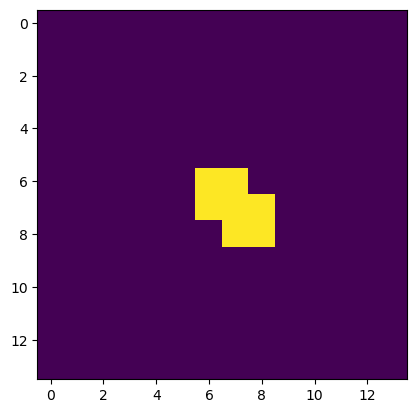

In [122]:
import random
from skimage import measure
import numpy as np
idx=0
sortedx = []
sortedy = []
for centroid in centroids:
    
    x = centroid[1] - radius
    y = centroid[0] - radius
    width = 2 * radius
    height = 2 * radius
    separated_image = mask[int(np.floor(y)):int(np.ceil(y+height)),int(np.floor(x)):int(np.ceil(x+width))]
    if idx == 0:
        separated_images = separated_image
    else:
        if separated_images.shape[1] == separated_image.shape[1]:
            if separated_image.shape[0] == 14:
                labeled_mask, num_clusters = measure.label(separated_image, background=0, return_num=True)
                if num_clusters == 1:
                    separated_images = np.vstack((separated_images, separated_image))
                    sortedx.append(x)
                    sortedy.append(y)
                
    idx+=1

# Save separated_images
#np.save('separated_images.npy', separated_images)

    # Save sortedx
#np.save('sortedx.npy', sortedx)

    # Save sortedy
#np.save('sortedy.npy', sortedy)

#plt.imshow(separated_images)
#plt.show()
ParticleBoxSize = separated_image.shape[1]
NParticlesZoo = int(np.floor((separated_images.shape[0])/ParticleBoxSize)-1)
#print(NParticles)

random_number = int(random.randint(0, NParticlesZoo))
print(random_number)
d = random_number

#print(NParticles)
plt.imshow(separated_images[ParticleBoxSize*d:ParticleBoxSize*(d+1),:])




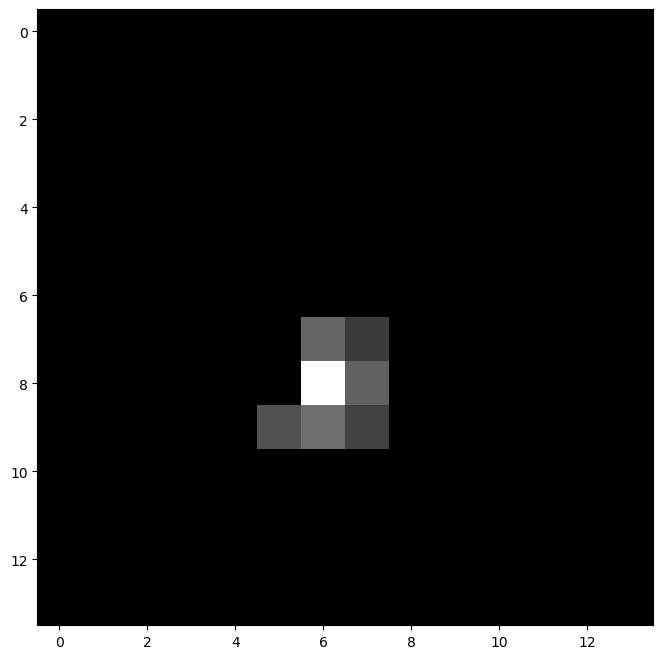

In [126]:
# Load image 2 filtered by mask
img2_path = 'data/interim/batch1/cam0/B00002.im7.png'
img2 = Image.open(img2_path)
img2 = np.array(img2)
q = int(random.randint(0, NParticlesZoo))
#print(sortedx[q])
imgx = img2[int(sortedy[q]):int(sortedy[q])+ParticleBoxSize,int(sortedx[q]):int(sortedx[q])+ParticleBoxSize]
maskx = mask[int(sortedy[q]):int(sortedy[q])+ParticleBoxSize,int(sortedx[q]):int(sortedx[q])+ParticleBoxSize]
# Plot the image in big format
plt.figure(figsize=(8, 8))
plt.imshow((imgx*maskx)[:,:250], cmap='gray')
plt.show()


Now simulated data

In [ ]:
    # ParticleZoo = np.zeros((ParticleBoxSize,ParticleBoxSize*NParticlesZoo))
    # for q in range(NParticlesZoo):
    #     imgx = img2[int(sortedy[q]):int(sortedy[q])+ParticleBoxSize,int(sortedx[q]):int(sortedx[q])+ParticleBoxSize]
    #     maskx = mask[int(sortedy[q]):int(sortedy[q])+ParticleBoxSize,int(sortedx[q]):int(sortedx[q])+ParticleBoxSize]
    #     ParticleZoo[:,ParticleBoxSize*q:ParticleBoxSize*(q+1)] = (imgx*maskx)[:,:]

    # np.save('ParticleZoo.npy', ParticleZoo)


In [1]:
import torch
import numpy as np
import os
import random
from PIL import Image
import matplotlib.pyplot as plt
current_dir = os.getcwd()
if "notebooks" in current_dir:
    current_dir = os.chdir("../")
CamDataNormalizedCumalative = torch.from_numpy(np.load('src/data/CamDataNormalizedCumalative.npy'))
ParticleZoo = torch.from_numpy(np.load('src/data/ParticleZoo.npy'))
ParticleBoxSize = 14
NParticlesZoo = int(np.floor((ParticleZoo.shape[1])/ParticleBoxSize))
def rdNoise(CamDataNormalizedCumalative, Shape):
    if isinstance(Shape, int):
        rdNumb = torch.searchsorted(CamDataNormalizedCumalative[:, 0], torch.rand(size=(Shape,)))
        return rdNumb
    else:
        Sizelength = Shape[0] * Shape[1]
        rdNumb = torch.searchsorted(CamDataNormalizedCumalative[:, 0], torch.rand(size=(Sizelength,)))
        rdNumb = rdNumb.reshape(Shape)
        return rdNumb

def gaussian(pos, mu, params):
    x, y = pos
    x0, y0 = mu
    A, sigma = params
    return A * torch.exp(-((x - x0) ** 2 + (y - y0) ** 2) / (2 * sigma ** 2))

def AddParticle(SimDomain,pos,ZooId):
    x, y = pos
    Nx=len(SimDomain[:,0])
    Ny=len(SimDomain[0,:])
    #print(Nx,Ny)
    img2_path = 'data/interim/batch1/cam0/B00002.im7.png'
    img2 = Image.open(img2_path)
    img2 = np.array(img2)
    # ParticleZoo = np.zeros((ParticleBoxSize,ParticleBoxSize*NParticlesZoo))
    # #q = int(random.randint(0, NParticles))
    # #print(sortedx[q])
    # #print(NParticlesZoo)
    # for q in range(NParticlesZoo):
    #     imgx = img2[int(sortedy[q]):int(sortedy[q])+ParticleBoxSize,int(sortedx[q]):int(sortedx[q])+ParticleBoxSize]
    #     maskx = mask[int(sortedy[q]):int(sortedy[q])+ParticleBoxSize,int(sortedx[q]):int(sortedx[q])+ParticleBoxSize]
    #     ParticleZoo[:,ParticleBoxSize*q:ParticleBoxSize*(q+1)] = (imgx*maskx)[:,:]
    # Plot the image in big format
    #ParticleZoo[:,14*ZooId:14*(ZooId+1)]
    #print(SimDomain.shape,(x,x+14,y,y+14))
    #print('hui')
    # if x+14<Nx and y+14<Ny:
        #print('hi')
        #x=Nx-14
    #print( SimDomain[x:x+14,y:y+14].shape,torch.tensor(ParticleZoo[:,14*ZooId:14*(ZooId+1)]).shape)
    if torch.tensor(ParticleZoo[:,14*ZooId:14*(ZooId+1)]).shape == SimDomain[x:x+14,y:y+14].shape:
        SimDomain[x:x+14,y:y+14] += torch.tensor(ParticleZoo[:,14*ZooId:14*(ZooId+1)])
        
    #SimDomain[x:x+14,y:y+14] += ParticleZoo[:,14*ZooId:14*(ZooId+1)]
    #print(SimDomain.shape)
    return SimDomain

def generate_images(num_images=5, x_dim=100, y_dim=100, NParticles=100, gauss_params=(60, 1), meanflow=15):
    dataset = []
    images = []
    positions_list = []
    gauss_masks = []
    flowrate = meanflow + max(min(np.random.normal(0, 1), 2), -2)
    Angle = np.random.uniform(0, 2 * np.pi)
    flowX = flowrate * np.cos(Angle)
    flowY = flowrate * np.sin(Angle)
    positions = torch.zeros((5, 2, NParticles))
    positions[0, 0, :] = torch.rand(NParticles) * (x_dim+meanflow*(num_images+1)+2*14)#-meanflow*(num_images+1)/2-14
    positions[0, 1, :] = torch.rand(NParticles) * (y_dim+meanflow*(num_images+1)+2*14)#-meanflow*(num_images+1)/2-14
    domainextention = meanflow*(num_images+1)+2*14+20
    #print(domainextention)
    sim_domain_plustime = torch.zeros((num_images ,x_dim, y_dim ))
    sim_domain_plustime_withNoise = torch.zeros((num_images ,x_dim, y_dim ))
    sim_domain_plustime_extended = torch.zeros((num_images ,x_dim+domainextention, y_dim+domainextention ))
    #print(positions)
    Label_domain = torch.zeros((x_dim, y_dim ))
    random_numbers = [random.randint(0, NParticlesZoo) for _ in range(NParticles)]
    for i in range(num_images):
        sim_domain = torch.zeros((x_dim, y_dim))
        #positions = torch.zeros((2, NParticles))
        positions[i, 0, :] = positions[0, 0, :]+flowX*i
        positions[i, 1, :] = positions[0, 1, :]+flowY*i
        #print(positions)
        x = torch.arange(x_dim)
        y = torch.arange(y_dim)
        x, y = torch.meshgrid(x, y)

        #print((int(positions[0, 0, 0]),int(positions[0, 1, 0])))
        for n in range(NParticles):
            sim_domain_plustime_extended[i,:,:] = AddParticle(sim_domain_plustime_extended[i,:,:],(int(positions[i, 0, n]),int(positions[i, 1, n])),ZooId=random_numbers[n])
        # plt.figure()
        # plt.imshow(sim_domain_plustime_extended[i,:,:])
        # plt.show()
        # #print(sim_domain_plustime_extended[i,int(domainextention/2):int(domainextention/2+100),int(domainextention/2):int(domainextention/2+100)].shape)
        sim_domain_plustime[i,:,:] = sim_domain_plustime_extended[i,int(domainextention/2):int(domainextention/2+100),int(domainextention/2):int(domainextention/2+100)]
        # for n in range(NParticles):
        #     gauss_paramsrnd = (gauss_params[0] + max(np.random.normal(0, 30), -60), gauss_params[1]+ max(np.random.normal(0, 0.5), -1))
        #     sim_domain += gaussian((x, y), positions[i, :, n], gauss_params).t()

        # Store the images and masks as tensors with 1 channel
        #noise = torch.normal(mean=0., std=noise_stddev, size=sim_domain.shape)
        noise = rdNoise(CamDataNormalizedCumalative, sim_domain.shape)
        



        # Store the images and masks as tensors with 1 channel
        sim_domain_plustime_withNoise[i,:,:] = sim_domain_plustime[i,:,:].unsqueeze(0) + 1.0*noise
        if i == round(num_images/2):
            #print(i,sim_domain_plustime[i,:,:].shape)
            Label_domain = sim_domain_plustime[i,:,:].unsqueeze(0)
            threshold = 20
            binary_mask = (Label_domain >= threshold).float()
            
        #sim_domain.unsqueeze(0)
        #positions_list.append(positions)
    #print(positions_list)
    #print(sim_domain_plustime)
    binary_mask = binary_mask.unsqueeze(0)
    #print(binary_mask[0][0].shape)
    return sim_domain_plustime_withNoise, binary_mask[0]
dataset = generate_images(5, 100, 100)
#print(dataset[0].shape,dataset[1].shape)

c:\Users\s174006\AppData\Local\anaconda3\lib\site-packages\torch\functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\b\abs_bao0hdcrdh\croot\pytorch_1675190257512\work\aten\src\ATen\native\TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
C:\Users\s174006\AppData\Local\Temp\ipykernel_13144\1930640440.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if torch.tensor(ParticleZoo[:,14*ZooId:14*(ZooId+1)]).shape == SimDomain[x:x+14,y:y+14].shape:
C:\Users\s174006\AppData\Local\Temp\ipykernel_13144\1930640440.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sour

C:\Users\s174006\AppData\Local\Temp\ipykernel_13144\1930640440.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if torch.tensor(ParticleZoo[:,14*ZooId:14*(ZooId+1)]).shape == SimDomain[x:x+14,y:y+14].shape:
C:\Users\s174006\AppData\Local\Temp\ipykernel_13144\1930640440.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  SimDomain[x:x+14,y:y+14] += torch.tensor(ParticleZoo[:,14*ZooId:14*(ZooId+1)])
C:\Users\s174006\AppData\Local\Temp\ipykernel_13144\393496718.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


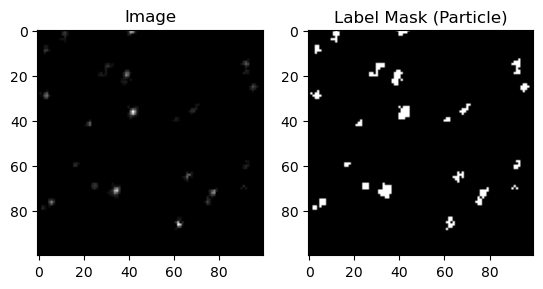

In [2]:
# Visualize an image and its corresponding label mask
def visualize_image(image, label):
    plt.figure()
    plt.title("Particle Detection")
    plt.subplot(1, 2, 1)
    plt.imshow(image[2].numpy(), cmap='gray')
    plt.title("Image")
    plt.subplot(1, 2, 2)
    plt.imshow(label[0].numpy(), cmap='gray')
    plt.title("Label Mask (Particle)")

# Create and visualize the dataset
#dataset = create_synthetic_dataset(num_samples=2)
dataset = generate_images(5, 100, 100)
#print(dataset)
image, label = dataset
#print(image[0].shape)
visualize_image(image, label)
# print the type of dataset
#print(dataset[0][1].shape)
#print the range of values in the image
#print(torch.max(dataset[0][0]))
#print(torch.min(dataset[0][0]))

plt.show()


### PARTICLES FILTERED BY MASK

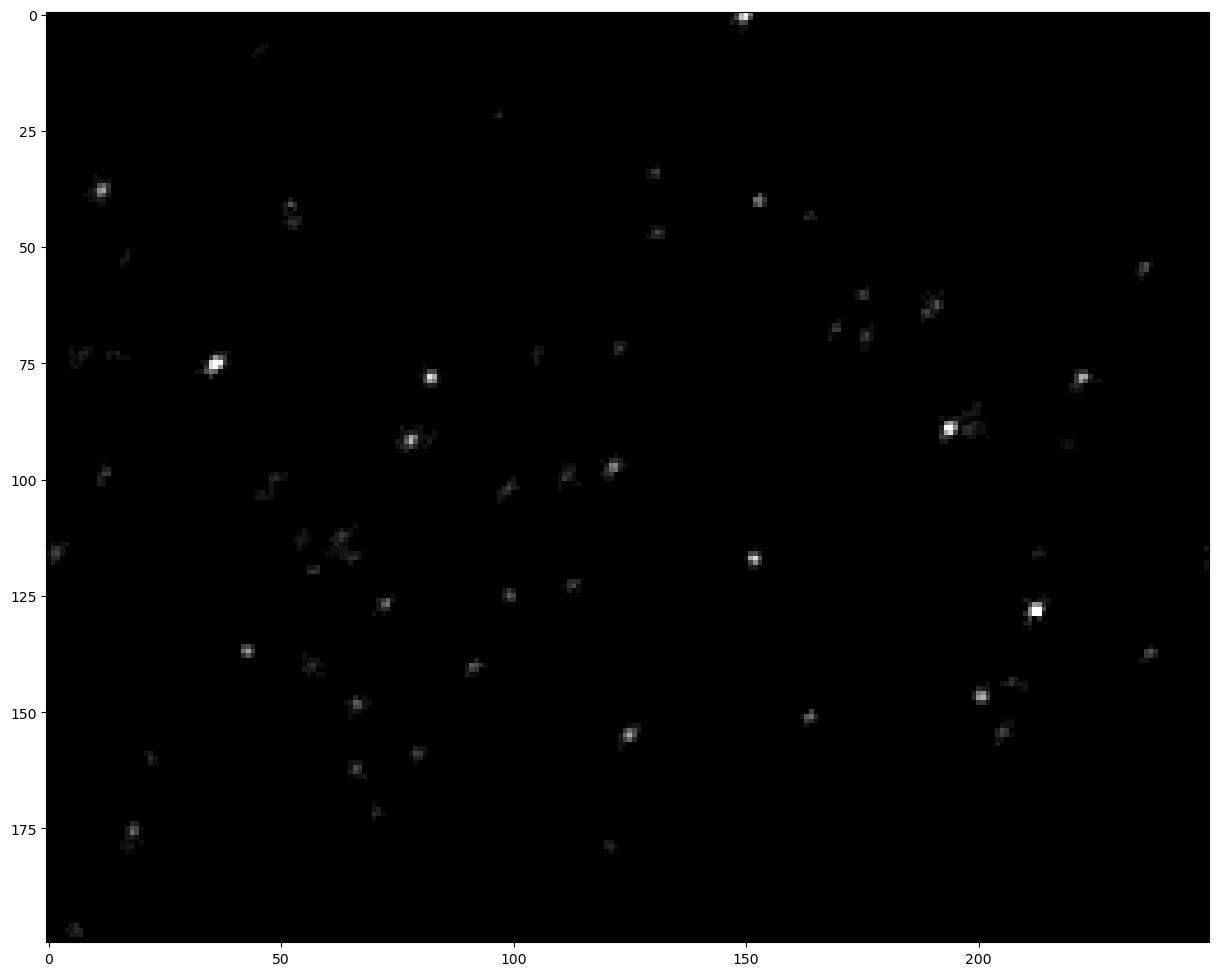

In [ ]:
# Load image 2 filtered by mask
img2_path = 'data/interim/batch1/cam0/B00002.im7.png'
img2 = Image.open(img2_path)
img2 = np.array(img2)

# Plot the image in big format
plt.figure(figsize=(15, 15))
plt.imshow((img2*mask)[:,:250], cmap='gray')
plt.show()